In [1]:
import simulation
import utils
import HminLower
import shannonLower
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import json
import ShannonEAT

## Recreating results on Shannon

In [ ]:
alphas = np.linspace(0.07, 1, 50)
betas = np.linspace(0.3, 0.9, 50)
vals = np.zeros((50, 50))
res = {'alphas': alphas, 'betas': betas, 'probas': []}

for i in range(50):
    for j in range(50):
        a = (alphas[i], betas[j])
        deltas, p = simulation.doSimul(a, 1/2, '3', 100000, 0.94)
        val = shannonLower.runOpti(deltas, p[0], 1/2, 'Faster', impl=1)
        vals[i,j] = val
        res['probas'].append(p)

res['vals'] = vals
with open("Results/Shannon3.json", 'w') as f:
    json.dump(res, f)

In [2]:
deltas, p = simulation.doSimul((5,5), 1/2, '3', 100000, 0.94)
deltas

(3.114440305444639e-09, 5.58071707349928e-05, 5.58071707349928e-05)

In [5]:
p[0]

{0: {0: 0.9391422121896162, 1: 0.0, 2: 0.46911225675715945},
 1: {0: 0.0, 1: 0.939671262568487, 2: 0.4728968620556069},
 2: {0: 0.06085778781038375, 1: 0.060328737431513034, 2: 0.05799088118723366}}

In [3]:
shannonLower.runOpti(deltas, p[0], 1/2, 'Faster', impl=1)

np.float64(-4.144948473339127e-08)

In [40]:
xticks = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
import seaborn as sns

plt.figure()
ax = sns.heatmap(vals, xticklabels=xticks, yticklabels=yticks, cmap='viridis')
ax.invert_yaxis()
plt.xlabel('Beta')
plt.ylabel('Alpha')
plt.title('Heatmap of f(alpha, beta)')

## Comparing Shannon and Hmin -- Same setup as from paper

In [2]:
delta, p = simulation.doSimul(60, 7/8, '1', 100000, 0.77, False)
shannonLower.runOpti(delta, p[0], 7/8)

np.float64(1.7335793778272546e-07)

In [4]:
delta

np.float64(0.0)

In [3]:
res1 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, False)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    res1['deltas'].append(delta)
    res1['vals'].append(val)
    res1['probas'].append(p)

with open('Results/Shannon1_077_NoDT.json', 'w') as f:
    json.dump(res1, f)

In [4]:
res2 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, True)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    res2['deltas'].append(delta)
    res2['vals'].append(val)
    res2['probas'].append(p)

with open('Results/Shannon1_077_DT.json', 'w') as f:
    json.dump(res2, f)

In [5]:
res3 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, False)
    val = HminLower.getHmin(p[0], delta, 7/8)

    res3['deltas'].append(delta)
    res3['vals'].append(val)
    res3['probas'].append(p)

with open('Results/Hmin1_077_NoDT.json', 'w') as f:
    json.dump(res3, f)

In [6]:
res4 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, True)
    val = HminLower.getHmin(p[0], delta, 7/8)

    res4['deltas'].append(delta)
    res4['vals'].append(val)
    res4['probas'].append(p)

with open('Results/Hmin1_077_DT.json', 'w') as f:
    json.dump(res4, f)

In [7]:
res5 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 1, False)
    p = utils.handle_non_phys(p, alpha, '1')
    val = shannonLower.runOpti(delta, p[0], 7/8)

    res5['deltas'].append(delta)
    res5['vals'].append(val)
    res5['probas'].append(p)

with open('Results/Shannon1_1_NoDT.json', 'w') as f:
    json.dump(res5, f)

In [8]:
res6 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 1, False)
    p = utils.handle_non_phys(p, alpha, '1')
    val = HminLower.getHmin(p[0], delta, 7/8)

    res6['deltas'].append(delta)
    res6['vals'].append(val)
    res6['probas'].append(p)

with open('Results/Hmin1_1_NoDT.json', 'w') as f:
    json.dump(res6, f)

In [9]:
alphas = [sqrt(alpha) for alpha in alphas]

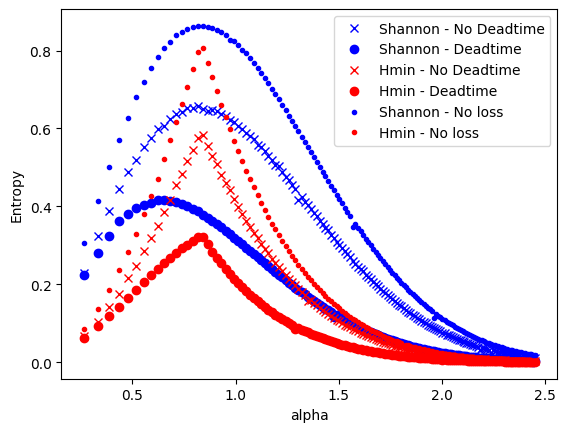

In [10]:
plt.figure()
plt.plot(alphas, res1['vals'], 'bx', label="Shannon - No Deadtime")
plt.plot(alphas, res2['vals'], 'bo', label="Shannon - Deadtime")
plt.plot(alphas, res3['vals'], 'rx', label="Hmin - No Deadtime")
plt.plot(alphas, res4['vals'], 'ro', label="Hmin - Deadtime")
plt.plot(alphas, res5['vals'], 'b.', label="Shannon - No loss")
plt.plot(alphas, res6['vals'], 'r.', label="Hmin - No loss")
plt.xlabel("alpha")
plt.ylabel("Entropy")
plt.legend()

In [10]:
res_1 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, False)
    val = shannonLower.runOpti(delta, p[0], 1/2)

    res_1['deltas'].append(delta)
    res_1['vals'].append(val)
    res_1['probas'].append(p)

with open('Results/Shannon2_077_NoDT.json', 'w') as f:
    json.dump(res_1, f)

In [11]:
res_2 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, True)
    val = shannonLower.runOpti(delta, p[0], 1/2)

    res_2['deltas'].append(delta)
    res_2['vals'].append(val)
    res_2['probas'].append(p)

with open('Results/Shannon2_077_DT.json', 'w') as f:
    json.dump(res_2, f)

In [12]:
res_3 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, False)
    val = HminLower.getHmin(p[0], delta, 1/2)

    res_3['deltas'].append(delta)
    res_3['vals'].append(val)
    res_3['probas'].append(p)

with open('Results/Hmin2_077_NoDT.json', 'w') as f:
    json.dump(res_3, f)

In [13]:
res_4 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, True)
    val = HminLower.getHmin(p[0], delta, 1/2)

    res_4['deltas'].append(delta)
    res_4['vals'].append(val)
    res_4['probas'].append(p)

with open('Results/Hmin2_077_DT.json', 'w') as f:
    json.dump(res_4, f)

In [14]:
res_5 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 1, False)
    p = utils.handle_non_phys(p, alpha, '2')
    val = shannonLower.runOpti(delta, p[0], 1/2)

    res_5['deltas'].append(delta)
    res_5['vals'].append(val)
    res_5['probas'].append(p)

with open('Results/Shannon2_1_NoDT.json', 'w') as f:
    json.dump(res_5, f)

In [15]:
res_6 = {'deltas': [], 'probas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 1, False)
    p = utils.handle_non_phys(p, alpha, '2')
    val = HminLower.getHmin(p[0], delta, 1/2)

    res_6['deltas'].append(delta)
    res_6['vals'].append(val)
    res_6['probas'].append(p)

with open('Results/Hmin2_1_NoDT.json', 'w') as f:
    json.dump(res_6, f)

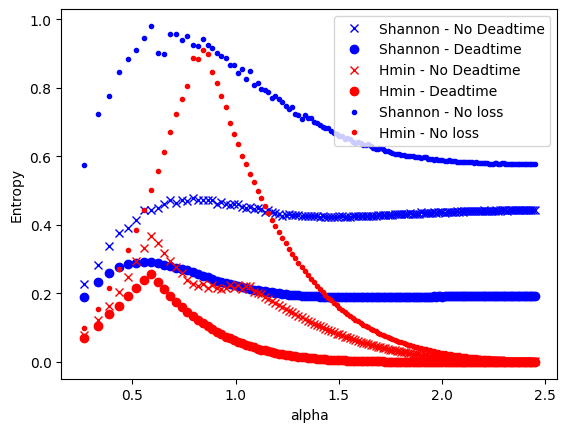

In [36]:
plt.figure()
plt.plot(alphas, res_1['vals'], 'bx', label="Shannon - No Deadtime")
plt.plot(alphas, res_2['vals'], 'bo', label="Shannon - Deadtime")
plt.plot(alphas, res_3['vals'], 'rx', label="Hmin - No Deadtime")
plt.plot(alphas, res_4['vals'], 'ro', label="Hmin - Deadtime")
plt.plot(alphas, res_5['vals'], 'b.', label="Shannon - No loss")
plt.plot(alphas, res_6['vals'], 'r.', label="Hmin - No loss")
plt.xlabel("alpha")
plt.ylabel("Entropy")
plt.legend()

## Taking delta -> 0

In [17]:
alphas = np.linspace(1, 1000, 50)
res01 = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, False)
    val = shannonLower.runOpti(delta, p[0], 1/2)

    res01['deltas'].append(delta)
    res01['vals'].append(val)
    res01['probas'].append(p)

with open('Results/Shannon2_077_NoDT_0.json', 'w') as f:
    json.dump(res01, f)

In [18]:
alphas = np.linspace(1, 1000, 50)
res02 = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, True)
    val = shannonLower.runOpti(delta, p[0], 1/2)

    res02['deltas'].append(delta)
    res02['vals'].append(val)
    res02['probas'].append(p)

with open('Results/Shannon2_077_DT_0.json', 'w') as f:
    json.dump(res02, f)

In [19]:
alphas = np.linspace(1, 1000, 50)
res03 = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, False)
    val = HminLower.getHmin(p[0], delta, 1/2)

    res03['deltas'].append(delta)
    res03['vals'].append(val)
    res03['probas'].append(p)

with open('Results/Hmin2_077_NoDT_0.json', 'w') as f:
    json.dump(res03, f)

In [20]:
alphas = np.linspace(1, 1000, 50)
res04 = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, True)
    val = HminLower.getHmin(p[0], delta, 1/2)

    res04['deltas'].append(delta)
    res04['vals'].append(val)
    res04['probas'].append(p)

with open('Results/Hmin2_077_DT_0.json', 'w') as f:
    json.dump(res04, f)

In [21]:
alphas = np.linspace(1, 1000, 50)
res05 = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 1, False)
    p = utils.handle_non_phys(p, alpha, '2')
    val = shannonLower.runOpti(delta, p[0], 1/2)

    res05['deltas'].append(delta)
    res05['vals'].append(val)
    res05['probas'].append(p)

with open('Results/Shannon2_1_NoDT_0.json', 'w') as f:
    json.dump(res05, f)

In [22]:
alphas = np.linspace(1, 1000, 50)
res06 = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 1, False)
    p = utils.handle_non_phys(p, alpha, '2')
    val = HminLower.getHmin(p[0], delta, 1/2)

    res06['deltas'].append(delta)
    res06['vals'].append(val)
    res06['probas'].append(p)

with open('Results/Hmin2_1_NoDT_0.json', 'w') as f:
    json.dump(res06, f)

In [37]:
res01['deltas']

[np.float64(0.36787944117144233),
 np.float64(2.177908910172276e-199),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0)]

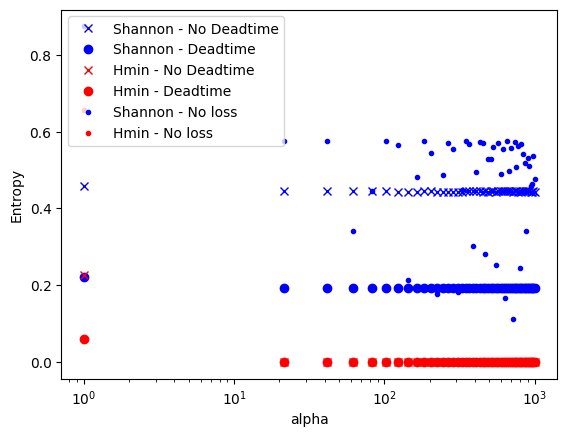

In [23]:
alphas = np.linspace(1, 1000, 50)
plt.figure()
plt.plot(alphas, res01['vals'], 'bx', label="Shannon - No Deadtime")
plt.plot(alphas, res02['vals'], 'bo', label="Shannon - Deadtime")
plt.plot(alphas, res03['vals'], 'rx', label="Hmin - No Deadtime")
plt.plot(alphas, res04['vals'], 'ro', label="Hmin - Deadtime")
plt.plot(alphas, res05['vals'], 'b.', label="Shannon - No loss")
plt.plot(alphas, res06['vals'], 'r.', label="Hmin - No loss")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("Entropy")
plt.legend()

In [24]:
alphas = np.linspace(1, 1000, 50)
res01_ = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, False)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    res01_['deltas'].append(delta)
    res01_['vals'].append(val)
    res01_['probas'].append(p)

with open('Results/Shannon1_077_NoDT_0.json', 'w') as f:
    json.dump(res01_, f)

In [25]:
alphas = np.linspace(1, 1000, 50)
res02_ = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, True)
    val = shannonLower.runOpti(delta, p[0], 7/8)

    res02_['deltas'].append(delta)
    res02_['vals'].append(val)
    res02_['probas'].append(p)

with open('Results/Shannon1_077_DT_0.json', 'w') as f:
    json.dump(res02_, f)

In [26]:
alphas = np.linspace(1, 1000, 50)
res03_ = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, False)
    val = HminLower.getHmin(p[0], delta, 7/8)

    res03_['deltas'].append(delta)
    res03_['vals'].append(val)
    res03_['probas'].append(p)

with open('Results/Hmin1_077_NoDT_0.json', 'w') as f:
    json.dump(res03_, f)

In [27]:
alphas = np.linspace(1, 1000, 50)
res04_ = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, True)
    val = HminLower.getHmin(p[0], delta, 7/8)

    res04_['deltas'].append(delta)
    res04_['vals'].append(val)
    res04_['probas'].append(p)

with open('Results/Hmin1_077_DT_0.json', 'w') as f:
    json.dump(res04_, f)

In [28]:
alphas = np.linspace(1, 1000, 50)
res05_ = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 1, False)
    p = utils.handle_non_phys(p, alpha, '1')
    val = shannonLower.runOpti(delta, p[0], 7/8)

    res05_['deltas'].append(delta)
    res05_['vals'].append(val)
    res05_['probas'].append(p)

with open('Results/Shannon1_1_NoDT_0.json', 'w') as f:
    json.dump(res05_, f)

In [29]:
alphas = np.linspace(1, 1000, 50)
res06_ = {'deltas': [], 'probas': [], 'vals': []}

for alpha in alphas:
    delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 1, False)
    p = utils.handle_non_phys(p, alpha, '1')
    val = HminLower.getHmin(p[0], delta, 7/8)

    res06_['deltas'].append(delta)
    res06_['vals'].append(val)
    res06_['probas'].append(p)

with open('Results/Hmin1_1_NoDT_0.json', 'w') as f:
    json.dump(res06_, f)

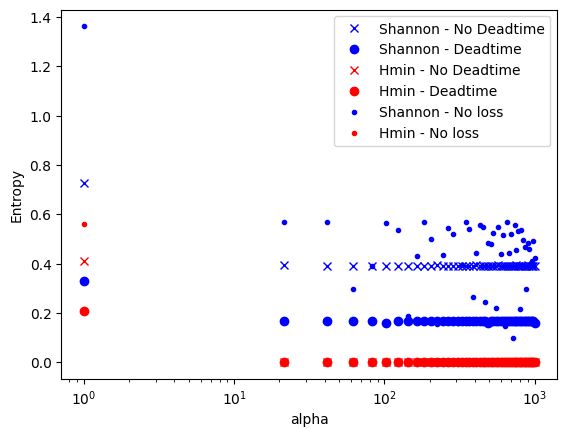

In [30]:
alphas = np.linspace(1, 1000, 50)
plt.figure()
plt.plot(alphas, res01_['vals'], 'bx', label="Shannon - No Deadtime")
plt.plot(alphas, res02_['vals'], 'bo', label="Shannon - Deadtime")
plt.plot(alphas, res03_['vals'], 'rx', label="Hmin - No Deadtime")
plt.plot(alphas, res04_['vals'], 'ro', label="Hmin - Deadtime")
plt.plot(alphas, res05_['vals'], 'b.', label="Shannon - No loss")
plt.plot(alphas, res06_['vals'], 'r.', label="Hmin - No loss")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("Entropy")
plt.legend()

## Comparing Shannon and EAT

In [31]:
res1e = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 100000, delta, 7/8)
    res1e['vals'].append(val)
    res1e['deltas'].append(delta)

with open('Results/ShannonEAT1_077_NoDT.json', 'w') as f:
    json.dump(res1e, f)

KeyboardInterrupt: 

In [ ]:
res2e = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 7/8, '1', 100000, 0.77, True)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 100000, delta, 7/8)
    res2e['vals'].append(val)
    res2e['deltas'].append(delta)

with open('Results/ShannonEAT1_077_DT.json', 'w') as f:
    json.dump(res2e, f)

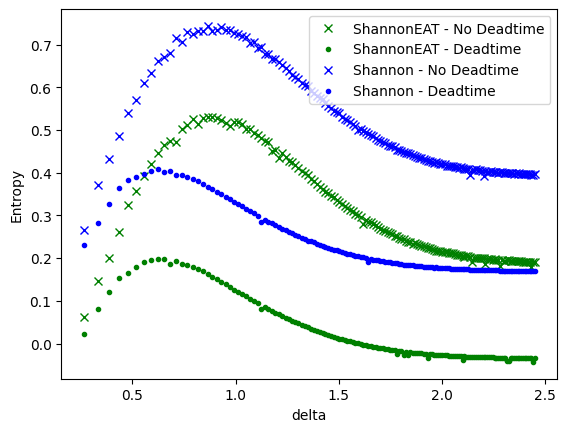

In [ ]:
plt.figure()
plt.plot(alphas, res1e['vals'], 'gx', label='ShannonEAT - No Deadtime')
plt.plot(alphas, res2e['vals'], 'g.', label='ShannonEAT - Deadtime')
plt.plot(alphas, res1['vals'], 'bx', label='Shannon - No Deadtime')
plt.plot(alphas, res2['vals'], 'b.', label='Shannon - Deadtime')
plt.xlabel('delta')
plt.ylabel('Entropy')
plt.legend()

In [ ]:
res1e_ = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, False)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 100000, delta, 1/2)
    res1e_['vals'].append(val)
    res1e_['deltas'].append(delta)

with open('Results/ShannonEAT2_077_NoDT.json', 'w') as f:
    json.dump(res1e_, f)

KeyboardInterrupt: 

In [ ]:
res2e_ = {'deltas': [], 'vals': []}
alphas = np.linspace(0.07, 6, 150)

for alpha in alphas:
    alpha = sqrt(alpha)
    ps = []
    delta = 0.0
    for i in range(5):
        delta, p = simulation.doSimul(alpha, 1/2, '2', 100000, 0.77, True)
        ps.append(p[0])
    val = ShannonEAT.getH(ps, 100000, delta, 1/2)
    res2e_['vals'].append(val)
    res2e_['deltas'].append(delta)

with open('Results/ShannonEAT2_077_DT.json', 'w') as f:
    json.dump(res2e_, f)

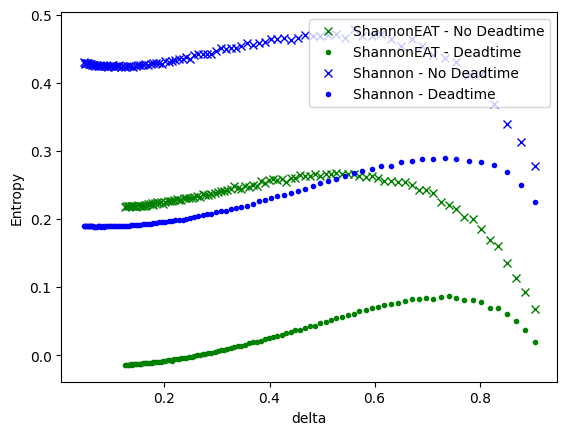

In [ ]:
plt.figure()
plt.plot(res1e_['deltas'], res1e_['vals'], 'gx', label='ShannonEAT - No Deadtime')
plt.plot(res2e_['deltas'], res2e_['vals'], 'g.', label='ShannonEAT - Deadtime')
plt.plot(res_1['deltas'], res_1['vals'], 'bx', label='Shannon - No Deadtime')
plt.plot(res_2['deltas'], res_2['vals'], 'b.', label='Shannon - Deadtime')
plt.xlabel('delta')
plt.ylabel('Entropy')
plt.legend()